# Monte‑Carlo Forecasts for the Top Solana Memecoin Wallets  
*Data source: 30‑day export from [Dune Analytics] dashboard*  

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, ipywidgets as w
from dataclasses import dataclass

RAW_PATH = 'dune_top30_traders_cleaned.csv'   # ensure the CSV lives next to this notebook
raw = pd.read_csv(RAW_PATH)
raw.head()

,Rank,Trader,# of memecoins,Avg ROI per token,# of trades,Spent,Avg spent per token,Received,Profit,profit_tokens,sol_balance,days_since_last_trade,win_rate,win_rate_0_100,win_rate_100_500,win_rate_500_1k,win_rate_1k_10k,win_rate_10k_100k,win_rate_more_100k
0,1,ETR2nhTSnq5uBgn8u3LPfsXkUJcQddsJnUYvHSafEFMG,117,992.93,445,98292.0,840.0,950696.0,852405.0,70,26.70,0,59.83,5.98,27.35,11.11,4.27,10.26,0.85
1,2,DtChGQTAyZEFdkWTHuKRjEZYJT2KiS56ocoAC5U1FMjR,121,574.44,277,78306.0,647.0,877692.0,799385.0,62,45.99,0,51.24,9.92,15.70,3.31,4.96,16.53,0.83
2,3,2LNQo1MGb7MN9S9fQA2s9K4vi9orceJMXyjMdLMjZuK1,116,803.49,358,91646.0,790.0,829403.0,737757.0,52,26.47,0,44.83,7.76,22.41,4.31,0.00,10.34,0.00
3,4,67LPayhALpHduuFaYnyPJXFsXGjvEP27pbf4wsvuyXVK,117,559.50,399,92285.0,789.0,786109.0,693824.0,53,29.71,0,45.30,16.24,15.38,1.71,0.85,11.11,0.00
4,5,J7CNwsukgYv1YtcHfL4tV2JwA9u6e5t3xmK9ioSdKTE8,56,463.26,233,68830.0,1229.0,708183.0,639353.0,38,62.78,0,67.86,26.79,10.71,8.93,3.57,14.29,3.57


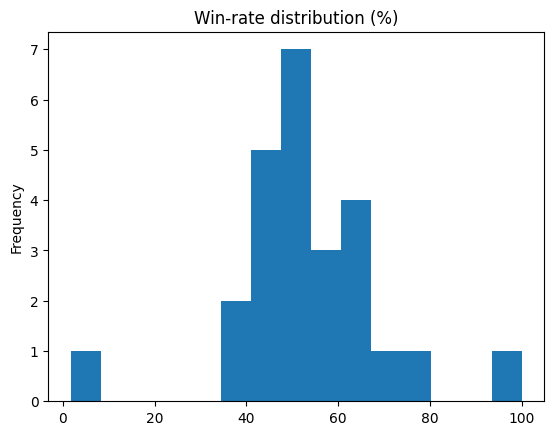

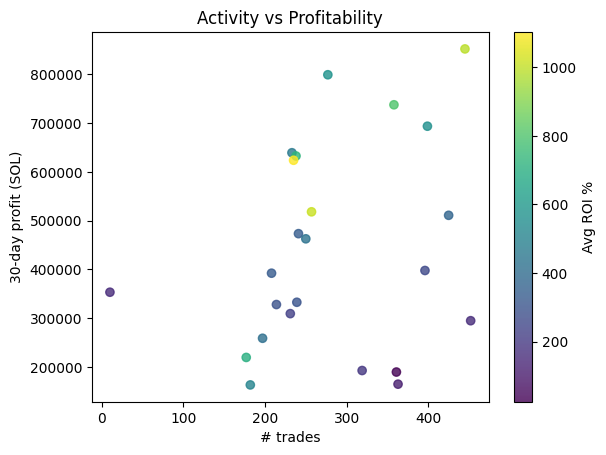

In [79]:
# Histogram of win‑rate
raw['win_rate'].plot.hist(bins=15); plt.title('Win‑rate distribution (%)'); plt.show()

# Trades vs Profit colored by Avg ROI
plt.scatter(raw['# of trades'], raw['Profit'], c=raw['Avg ROI per token'], alpha=0.8)
plt.colorbar(label='Avg ROI %'); plt.xlabel('# trades'); plt.ylabel('30‑day profit (SOL)')
plt.title('Activity vs Profitability'); plt.show()

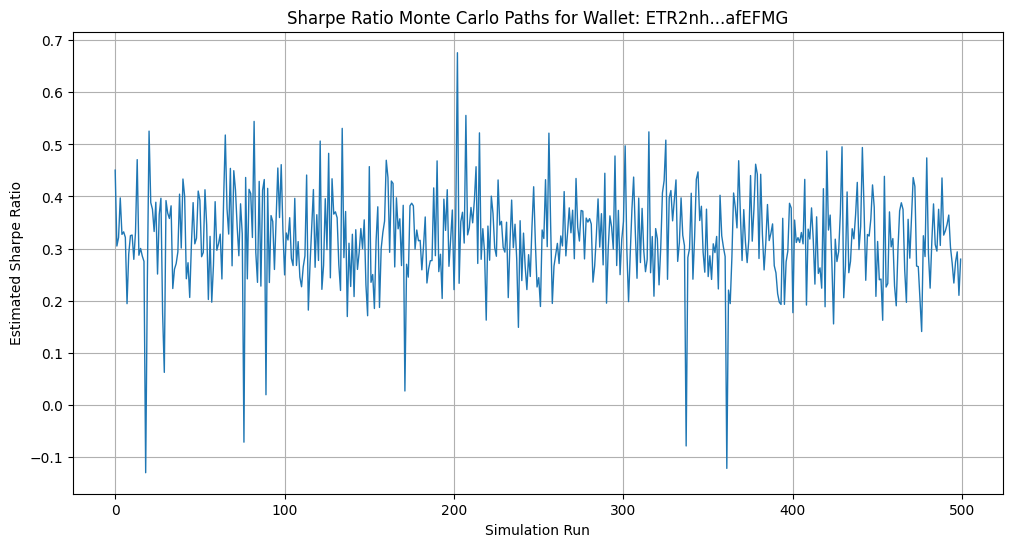

Predicted Sharpe Ratio for wallet ETR2nh...afEFMG: 0.3199


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('dune_top30_traders_cleaned.csv')

# --- Functions ---

def run_monte_carlo_sharpe(row, n_simulations=500, n_days=30, return_all=False):
    def sample_win_from_buckets(row):
        buckets = [
            ('win_rate_0_100', 0, 100),
            ('win_rate_100_500', 100, 500),
            ('win_rate_500_1k', 500, 1000),
            ('win_rate_1k_10k', 1000, 10000),
            ('win_rate_10k_100k', 10000, 100000),
            ('win_rate_more_100k', 100000, 300000)
        ]
        probs = [row[bucket[0]] for bucket in buckets]
        probs = np.array(probs)
        probs = probs / probs.sum()
        chosen_idx = np.random.choice(len(buckets), p=probs)
        low, high = buckets[chosen_idx][1], buckets[chosen_idx][2]
        return np.random.uniform(low, high)

    def sample_loss_from_normal(row):
        avg_trade_size = row['Avg spent per token']
        mean_loss = -0.5 * avg_trade_size
        std_dev_loss = 0.25 * avg_trade_size
        loss = np.random.normal(mean_loss, std_dev_loss)
        loss = np.clip(loss, -avg_trade_size, 0)
        return loss

    win_rate = row['win_rate'] / 100

    sharpe_estimates = []
    for _ in range(n_simulations):
        daily_returns = []
        for _ in range(n_days):
            if np.random.rand() < win_rate:
                daily_returns.append(sample_win_from_buckets(row))
            else:
                daily_returns.append(sample_loss_from_normal(row))
        daily_returns = np.array(daily_returns)
        mean_return = np.mean(daily_returns)
        std_return = np.std(daily_returns) + 1e-8
        sharpe_ratio = mean_return / std_return
        sharpe_estimates.append(sharpe_ratio)

    if return_all:
        return sharpe_estimates
    else:
        return np.mean(sharpe_estimates)

# --- Run for one wallet and plot ---

# Specify wallet manually
wallet_input = 'ETR2nhTSnq5uBgn8u3LPfsXkUJcQddsJnUYvHSafEFMG'  # Example

# Find the row
wallet_row = df[df['Trader'] == wallet_input].iloc[0]

# Run simulation
sharpe_paths = run_monte_carlo_sharpe(wallet_row, n_simulations=500, n_days=30, return_all=True)

# Plot the Monte Carlo paths
plt.figure(figsize=(12, 6))
plt.plot(range(len(sharpe_paths)), sharpe_paths, lw=1)
plt.xlabel('Simulation Run')
plt.ylabel('Estimated Sharpe Ratio')
plt.title(f'Sharpe Ratio Monte Carlo Paths for Wallet: {wallet_input[:6]}...{wallet_input[-6:]}')
plt.grid(True)
plt.show()

# Print final predicted Sharpe
predicted_sharpe = np.mean(sharpe_paths)
print(f"Predicted Sharpe Ratio for wallet {wallet_input[:6]}...{wallet_input[-6:]}: {predicted_sharpe:.4f}")


In [81]:
# --- Run Simulation Across All Wallets ---

wallet_sharpe_estimates = {}

# Loop through each wallet
for idx, row in df.iterrows():
    wallet = row['Trader']
    avg_sharpe = run_monte_carlo_sharpe(row, n_simulations=1000, n_days=30)  # only get the average, no paths
    wallet_sharpe_estimates[wallet] = avg_sharpe

# --- Print Final Results ---

for wallet, sharpe in sorted(wallet_sharpe_estimates.items(), key=lambda x: x[1], reverse=True):
    print(f"Wallet {wallet[:6]}...{wallet[-6:]} -> Estimated Sharpe: {sharpe:.4f}")


Wallet 9kf7oy...aRYiuv -> Estimated Sharpe: 3.5619
Wallet 2nXg2X...bzgziD -> Estimated Sharpe: 0.9308
Wallet 3xEwyE...tcGyiE -> Estimated Sharpe: 0.4495
Wallet 8zkJme...iMdCVp -> Estimated Sharpe: 0.4470
Wallet BsjAKW...FtHVz2 -> Estimated Sharpe: 0.4465
Wallet FnVniP...VHZF9B -> Estimated Sharpe: 0.4115
Wallet DtChGQ...U1FMjR -> Estimated Sharpe: 0.4024
Wallet 7DCP97...g9rSj5 -> Estimated Sharpe: 0.3996
Wallet HZvm3U...YHvVEH -> Estimated Sharpe: 0.3987
Wallet RPDqch...KsTZee -> Estimated Sharpe: 0.3906
Wallet J7CNws...SdKTE8 -> Estimated Sharpe: 0.3831
Wallet HRayAs...jNQ5uJ -> Estimated Sharpe: 0.3776
Wallet 3R2oe2...5ec5M8 -> Estimated Sharpe: 0.3766
Wallet BdJzu3...jBUu5D -> Estimated Sharpe: 0.3589
Wallet ETR2nh...afEFMG -> Estimated Sharpe: 0.3234
Wallet 55JgKg...51zMPV -> Estimated Sharpe: 0.3108
Wallet 4Eqa4U...uPRZiV -> Estimated Sharpe: 0.3101
Wallet 5urHgx...trVNaa -> Estimated Sharpe: 0.3053
Wallet 67LPay...vuyXVK -> Estimated Sharpe: 0.3012
Wallet eBDK8X...yjSNvr -> Estim

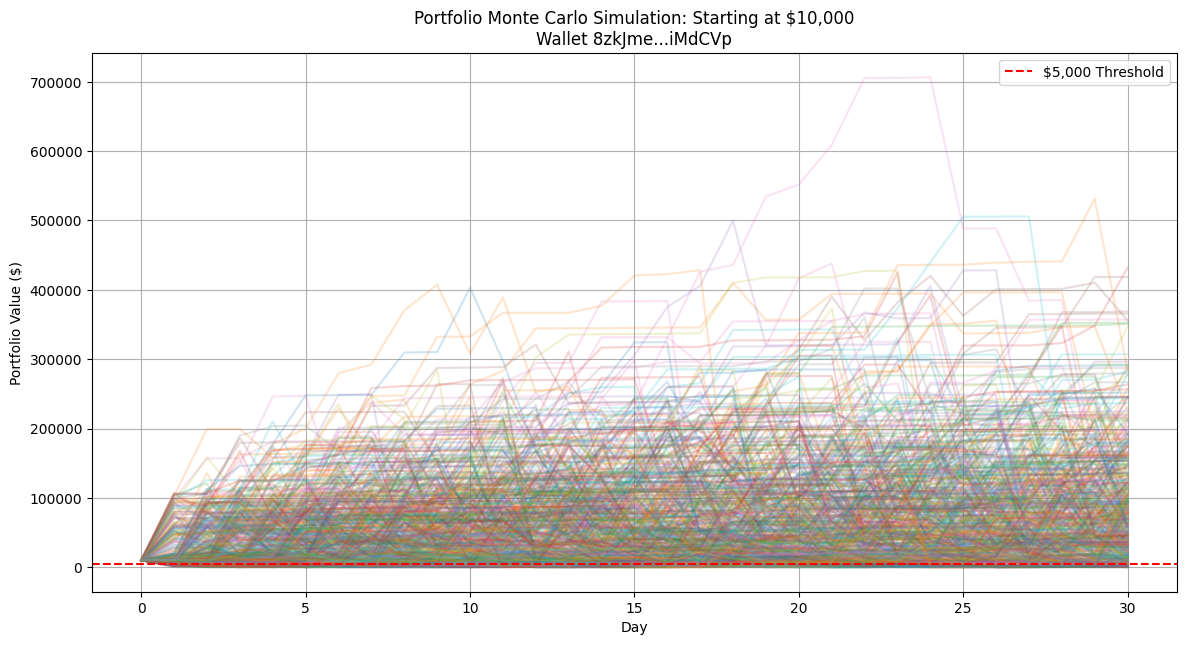

Average Ending Portfolio Value after 30 days: $87332.38
Percentage of simulations where portfolio fell below $5,000: 70.20%


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('dune_top30_traders_cleaned.csv')

# --- Portfolio Simulation Function ---

def run_portfolio_monte_carlo(row, starting_balance=10000, n_simulations=500, n_days=30):
    def sample_win_from_buckets(row):
        buckets = [
            ('win_rate_0_100', 0, 100),
            ('win_rate_100_500', 100, 500),
            ('win_rate_500_1k', 500, 1000),
            ('win_rate_1k_10k', 1000, 10000),
            ('win_rate_10k_100k', 10000, 100000),
            ('win_rate_more_100k', 100000, 200000)
        ]
        probs = [row[bucket[0]] for bucket in buckets]
        probs = np.array(probs)
        probs = probs / probs.sum()
        chosen_idx = np.random.choice(len(buckets), p=probs)
        low, high = buckets[chosen_idx][1], buckets[chosen_idx][2]
        return np.random.uniform(low, high)

    def sample_loss_from_normal(current_portfolio_value):
        mean_loss = -0.5 * current_portfolio_value
        std_dev_loss = 0.25 * current_portfolio_value
        loss = np.random.normal(mean_loss, std_dev_loss)
        loss = np.clip(loss, -current_portfolio_value, 0)
        return loss

    win_rate = row['win_rate'] / 100

    portfolio_paths = []
    for _ in range(n_simulations):
        portfolio_value = starting_balance
        daily_values = [portfolio_value]
        for _ in range(n_days):
            if np.random.rand() < win_rate:
                change = sample_win_from_buckets(row)
            else:
                change = sample_loss_from_normal(portfolio_value)
            portfolio_value += change
            daily_values.append(portfolio_value)
        portfolio_paths.append(daily_values)

    return np.array(portfolio_paths)

# --- Run for One Wallet and Plot ---

# Specify wallet manually
wallet_input = '8zkJmeQS1J3GUkPvfboeT76bwojADU6dyTZsCBiMdCVp'  # Example

# Find the row
wallet_row = df[df['Trader'] == wallet_input].iloc[0]

# Run portfolio simulation
portfolio_paths = run_portfolio_monte_carlo(wallet_row, starting_balance=10000, n_simulations=500, n_days=30)

# --- PLOT ---

plt.figure(figsize=(14, 7))
for path in portfolio_paths:
    plt.plot(path, alpha=0.2)
plt.xlabel('Day')
plt.ylabel('Portfolio Value ($)')
plt.title(f'Portfolio Monte Carlo Simulation: Starting at $10,000\nWallet {wallet_input[:6]}...{wallet_input[-6:]}')
plt.axhline(5000, color='red', linestyle='--', label='$5,000 Threshold')  # optional red line at $5,000
plt.legend()
plt.grid(True)
plt.show()

# --- PRINT FINAL STATS ---

ending_balances = portfolio_paths[:, -1]
mean_ending_balance = np.mean(ending_balances)

# % of paths that fell below $5,000 at any point
fell_below_5k = np.sum((portfolio_paths <= 5000).any(axis=1))
percent_below_5k = (fell_below_5k / portfolio_paths.shape[0]) * 100

print(f"Average Ending Portfolio Value after 30 days: ${mean_ending_balance:.2f}")
print(f"Percentage of simulations where portfolio fell below $5,000: {percent_below_5k:.2f}%")
